<a href="https://colab.research.google.com/github/Mulac/TDA-MNIST/blob/master/approach_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np 
import matplotlib.pyplot as plt
from skimage.util import random_noise
from time import perf_counter

## Prepare Data
1. Download data and apply tranformations

In [2]:
tfms_train = transforms.Compose([transforms.Resize(size=28),
                                 transforms.ToTensor()])
tfms_valid = transforms.ToTensor()

In [3]:
train = torchvision.datasets.MNIST('./data/train', train=True, transform=tfms_train, download=True)
valid = torchvision.datasets.MNIST('./data/valid', train=False,transform=tfms_valid, download=True)

Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw


Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw


Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw


Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./data/valid/MNIST/raw/train-images-idx3-ubyte.gz to ./data/valid/MNIST/raw


Extracting ./data/valid/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/valid/MNIST/raw


Extracting ./data/valid/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/valid/MNIST/raw


Extracting ./data/valid/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/valid/MNIST/raw
Processing...
Done!


2. Check the data has right number of examples

In [4]:
print(train)
print(valid)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/valid
    Split: Test
    StandardTransform
Transform: ToTensor()


3. Show the first training example and corresponding label (target)

Shape: torch.Size([28, 28])
Label: 5





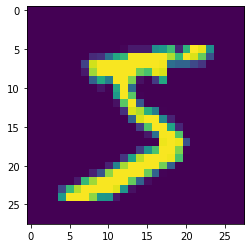

In [5]:
example = 0

img, label = train.data[example], train.targets[example]
print("Shape:", img.shape)
print("Label:", label.item())
plt.imshow(img)

# Data Augmentation
The data we have can be altered in various ways to provide more data (based on what we already have).
This can include:


*   Flipping (can't be used in this context - except for maybe 8 and 0)
*   Rotating (slightly, so the number is still upright)
*   Scaling
*   Cropping
*   Translating
*   Adding **Gaussian noise** - helps prevent overfitting by distorting high frequency features. **Salt and pepper noise** can be used as well (b&w static-like noise)

An example is shown below. This will be applied to each batch of images in the training loop after the originals have been used to train the network.


In [6]:
  # Randomly tilts the image by -15 to 15 deg
  # Randomly translates image by -26*0.2 to -26*0.2 horizontally or vertically
  # Randomly scales image by 0.5x to 1x
  # Adds gaussian noise
augmentations = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomAffine(degrees=15, translate=(0.2,0.2), scale=(0.5,1)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: torch.from_numpy(random_noise(x, mode='gaussian', mean=0, var=0.05, clip=True, seed = 63)))])

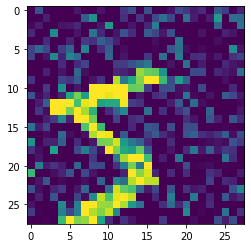

In [7]:
aug_img = augmentations(img)
plt.imshow(aug_img.squeeze())

## Create Model
Two ways to do this.  Either by inheriting from the Module class or by using nn.Sequential

In [8]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
  
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
    self.adapt = nn.AdaptiveMaxPool2d(5)
    self.linear1 = nn.Linear(800, 120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn.Linear(84, 10) 
  
  def forward(self, input):
    result = self.conv1(input)
    result = F.relu(result)
    result = self.pool(result)

    result = self.conv2(result)
    result = F.relu(result)
    result = self.pool(result)

    result = self.conv3(result)
    result = F.relu(result)
    result = self.adapt(result)

    result = result.view(result.size(0), -1) 
    result = self.linear1(result)
    result = self.linear2(result)
    result = self.linear3(result)
    return result

### Define training loop

Grab batch from data loader; make model predictions; calculate loss; compute gradients; update weights;

**Data augmentation takes place here**

In [9]:
class Learner():
  
  def __init__(self, model, lr, train, valid):
    self.model = model
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
    self.criterion = torch.nn.CrossEntropyLoss()
    self.train_loader = train
    self.valid_loader = valid
    self.transform = augmentations
  
  def fit(self, epochs, augment=True, evaluate=True):
    self.model.train()

    for e in range(epochs):
      start = perf_counter()
      self.train(augment)
      end = perf_counter()
      if evaluate:
        print("epoch", (e + 1), " | accuracy", round(self.eval(),3), 
              "% | time: ", round((end-start),3), " seconds")

  def train(self, augment):
    for imgs, labels in self.train_loader:
      if augment:
        self.augment_images(imgs)

      pred = self.model(imgs)
      loss = self.criterion(pred, labels)

      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
    
    if augment:
      self.train(False)

  def eval(self):
    self.model.eval()

    with torch.no_grad():
      correct = 0
      for images, labels in self.valid_loader:
        predicted = torch.argmax(self.model(images),dim=1)
        correct += (predicted == labels).sum().item()

    return correct / len(self.valid_loader.dataset) * 100

  def augment_images(self,images):
    """  Applys a given series of transformations to a batch of images  """
    for i in range(len(images)):
        images[i] = self.transform(images[i])

  def confusion_matrix(self):
    """ Returns the matrix of preditions against ground truths of validation """
    self.model.eval()
    confusion_matrix = np.array([[0]*10]*10)

    with torch.no_grad():
      for image, label in self.valid_loader:
        pred = torch.argmax(self.model(image), dim=1)
        confusion_matrix[label][pred] += 1
    
    return confusion_matrix

In [10]:
# When performing evaluation it's good to work in the torch.no_grad context,
# this will save memory and won't compute any gradients

def plot_accuracy(matrix):
  fig, ax = plt.subplots()
  im = ax.imshow(matrix)
  axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Showing all ticks
  ax.set_xticks(np.arange(10))
  ax.set_yticks(np.arange(10))
  # Giving labels to ticks and axes
  ax.set_xticklabels(axis)
  ax.set_yticklabels(axis)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Prediction')
  # Creating text annotations for each cell
  for i in range(10):
      for j in range(10):
          text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w")
  ax.set_title("Model Predictions vs Actual")
  fig.tight_layout()
  return plt.show()


### Choose loss function and optimiser
e.g. Mean Squared Error (MSE) with Stochastic Gradient Decent (SGD)

In [11]:
valid_loader = torch.utils.data.DataLoader(valid)

criterion = torch.nn.CrossEntropyLoss()
#learning_rates = [0.1, 0.01, 0.001]
lrs = np.arange(0.1, 0, -0.01)

learning_rates = list(lrs)
print(learning_rates)
batch_sizes = [5, 10, 20, 40, 64]
BATCH_SIZE = 5


[0.1, 0.09000000000000001, 0.08000000000000002, 0.07000000000000002, 0.060000000000000026, 0.05000000000000003, 0.040000000000000036, 0.03000000000000004, 0.020000000000000046, 0.01000000000000005]


### Evaluate Model
Uses the validation set to test the model

epoch 1  | accuracy 9.58 % | time:  67.643  seconds
epoch 2  | accuracy 9.58 % | time:  67.362  seconds
epoch 3  | accuracy 9.58 % | time:  67.154  seconds


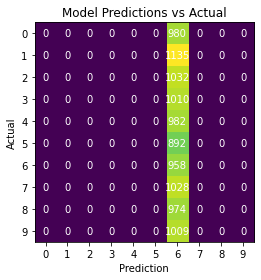

epoch 1  | accuracy 93.03 % | time:  68.21  seconds
epoch 2  | accuracy 80.27 % | time:  68.324  seconds
epoch 3  | accuracy 9.58 % | time:  67.306  seconds


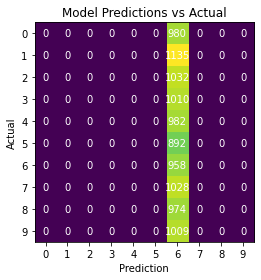

epoch 1  | accuracy 94.26 % | time:  68.172  seconds
epoch 2  | accuracy 92.46 % | time:  68.243  seconds
epoch 3  | accuracy 93.16 % | time:  68.049  seconds


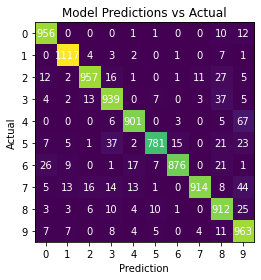

epoch 1  | accuracy 95.19 % | time:  68.14  seconds
epoch 2  | accuracy 84.43 % | time:  68.348  seconds
epoch 3  | accuracy 95.85 % | time:  68.134  seconds


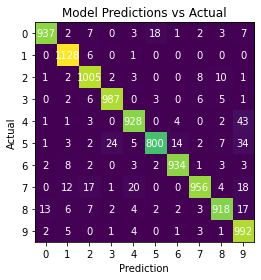

epoch 1  | accuracy 96.69 % | time:  68.128  seconds
epoch 2  | accuracy 96.69 % | time:  68.335  seconds
epoch 3  | accuracy 97.49 % | time:  68.099  seconds


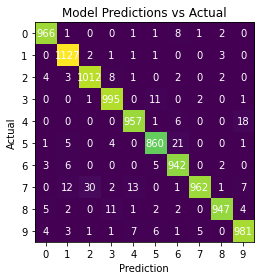

epoch 1  | accuracy 97.59 % | time:  68.531  seconds
epoch 2  | accuracy 97.51 % | time:  68.011  seconds
epoch 3  | accuracy 97.19 % | time:  67.822  seconds


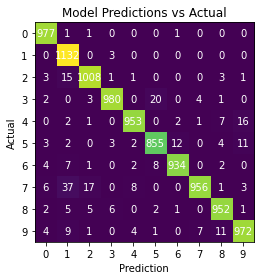

epoch 1  | accuracy 97.77 % | time:  68.242  seconds
epoch 2  | accuracy 98.0 % | time:  67.822  seconds
epoch 3  | accuracy 98.37 % | time:  67.504  seconds


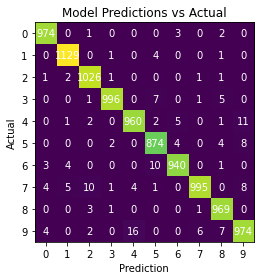

epoch 1  | accuracy 98.02 % | time:  68.211  seconds
epoch 2  | accuracy 98.46 % | time:  68.254  seconds
epoch 3  | accuracy 98.51 % | time:  68.058  seconds


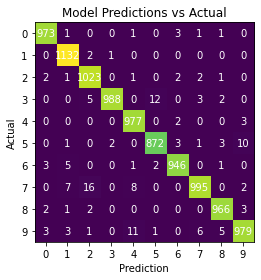

epoch 1  | accuracy 97.73 % | time:  68.14  seconds
epoch 2  | accuracy 98.44 % | time:  68.623  seconds
epoch 3  | accuracy 97.86 % | time:  68.818  seconds


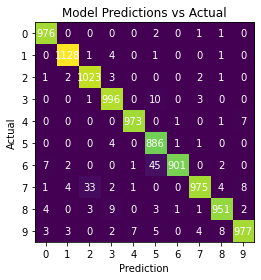

epoch 1  | accuracy 97.3 % | time:  69.178  seconds
epoch 2  | accuracy 98.19 % | time:  69.477  seconds
epoch 3  | accuracy 98.48 % | time:  69.502  seconds


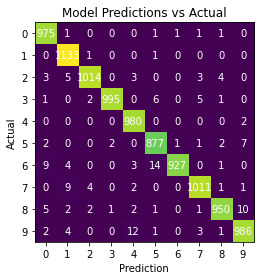

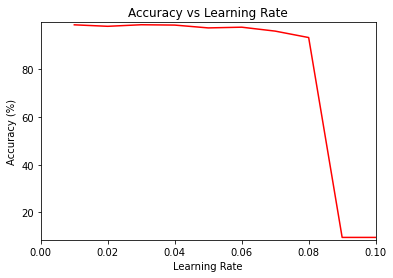

In [13]:
accuracies = []
#cumulative_time = 0
for lr in learning_rates:
  model = CNN()
  learner = Learner(model, lr, torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle=False), valid_loader)
  learner.fit(3, augment=False, evaluate=True) # augment and evalute off for speed
  accuracies.append(learner.eval())#####
  plot_accuracy(learner.confusion_matrix())

plt.plot(learning_rates, accuracies, 'r-') #####
plt.axis([0, max(learning_rates), min(accuracies)-1, max(accuracies)+1]) #####
plt.title('Accuracy vs Learning Rate') #####
plt.xlabel('Learning Rate') #####
plt.ylabel('Accuracy (%)') #####
plt.show() #####


In [ ]:
accuracies = []
for size in batch_sizes:
  model = CNN()
  lr = 0.01
  learner = Learner(model, lr, torch.utils.data.DataLoader(train, batch_size = size, shuffle=False), valid_loader)
  accuracies.append(learner.fit(3))#####
  plot_accuracy(learner.confusion_matrix())

plt.plot(batch_sizes, accuracies, 'b-') #####
plt.axis([0, max(batch_sizes), min(accuracies)-1, max(accuracies)+1]) #####
plt.title('Accuracy vs Batch Size') #####
plt.xlabel('Batch Size') #####
plt.ylabel('Accuracy (%)') #####
plt.show() #####

In [ ]:
print(accuracy)
x = np.arange(1, epochs+1)
print(x)
plt.xticks(x, x)
plt.plot(x, accuracy, 'r-') 
plt.axis([1, epochs, min(accuracy)-1, max(accuracy)+1])
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

## Visualisation

We create a class that allows us to inspect individual layers in our neural network using hooks.

In [ ]:
cnn = CNN()
learner = Learner(cnn, 0.01, torch.utils.data.DataLoader(train, batch_size=5), valid_loader)
learner.fit(1, augment=False)
plot_accuracy(learner.confusion_matrix())

In [ ]:
## visualises each kernel 
plots = []
convlayer = 0
children = list(learner.model.children())
for i in range(1):
  if type(children[i]) == nn.Conv2d:
    plots.append(plt.figure(figsize=(10, 20)))
    cw = children[i].weight
    for j in range(16):
      plots[convlayer].add_subplot(10, 10, j+1)
      plt.axis('off')
      plt.imshow(cw[j][0,:,:].detach())
    convlayer += 1

In [ ]:
class LayerVisualisation():
  """ 
    Allows us to inspect an indivdual convolutional layer in a neural network.
  """

  def __init__(self, model, layer):
    self.model = model
    self.model.eval()
    self.sel_layer = list(self.model.children())[layer]
    print(self.sel_layer)
    self.hook = self.sel_layer.register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.activations = output[0]

  def show_kernels(self):
    ...
  
  def show_activations(self):
    ...

  def visualise_filter(self, filter_id, lr=0.1, steps=30):
    """ Returns an image that maximally excites the given filter """
    random_image = torch.rand((1, 1, 28, 28), requires_grad=True)
    optimizer = torch.optim.Adam([random_image], lr=lr, weight_decay=1e-8)

    for step in range(steps):
      optimizer.zero_grad()
      self.model(random_image)
      loss = -self.activations[filter_id].mean()
      loss.backward()
      optimizer.step()

    random_image.requires_grad = False
    return random_image
  
  def close(self):
    self.hook.remove()

In [ ]:
def show_filters(layer, number):
  plt.figure(figsize=(20, 20))
  for i in range(number):
    filter = layer.visualise_filter(i)
    plt.subplot(8, 8, i+1)
    plt.axis('off') 
    plt.imshow(filter.squeeze())

In [ ]:
conv1 = LayerVisualisation(learner.model, 0)
show_filters(conv1 ,16) ## first convolutional layer

In [ ]:
conv2 = LayerVisualisation(learner.model, 2)
show_filters(conv2 ,32) ## second convolutional layer

In [ ]:
conv3 = LayerVisualisation(learner.model, 3)
show_filters(conv3, 20) ## third convolutional layer

In [ ]:
outputs = LayerVisualisation(learner.model, 7)
show_filters(outputs ,10) ## final linear layer

**Let's look at the result of sending these optimized images through the network**

In [ ]:
img, _ = next(iter(valid_loader))
plt.imshow(img.squeeze())

In [ ]:
F.softmax(learner.model(img))

In [ ]:
num = outputs.visualise_filter(7)
F.softmax(learner.model(num))

In [ ]:
with torch.no_grad():
  image, label = next(iter(valid_loader))
  print(image.shape)
  learner.model(image)

plt.imshow(image.squeeze())

In [ ]:
fig = plt.figure(figsize=(10, 10)) 

for filter, map in enumerate(conv2.activations):
  ax = fig.add_subplot(6, 6, filter+1, xticks=[], yticks=[])
  ax.imshow(map)

** The following model gives an accuracy of around 99.07%**



In [ ]:
class CNN_2(nn.Module):

  def __init__(self):
    super(CNN_2, self).__init__()
  
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
    self.adapt = nn.AdaptiveMaxPool2d(5)
    self.linear2 = nn.Linear(800, 128)
    self.linear3 = nn.Linear(128, 10) 
  
  def forward(self, input):
    result = self.conv1(input)
    result = F.relu(result)
    result = self.pool(result)

    result = self.conv2(result)
    result = F.relu(result)

    result = self.adapt(result)

    result = result.view(result.size(0), -1) 
    result = self.linear2(result)
    result = self.linear3(result)
    return result

In [ ]:
cnn_2 = CNN_2()
learner_2 = Learner(CNN_2, 0.01, torch.utils.data.DataLoader(train, batch_size=5), valid_loader)
learner_2.fit(10, augment=True)
plot_accuracy(learner_2.confusion_matrix())   